In [1]:
import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
# import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

# Calculate MI for ABIDE data age and diagnosis outcome
## creating job submission scripts

In [2]:
# # running PCA on it

# import numpy as np
# import pandas as pd
# from dask import dataframe as dd
# import matplotlib.pyplot as plt
# from scipy.stats import kendalltau, rankdata, norm
# import fastHDMI as mi
# from sklearn.model_selection import train_test_split, GridSearchCV
# from sklearn.preprocessing import StandardScaler, SplineTransformer
# from sklearn.decomposition import PCA
# from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
# from sklearn.neural_network import MLPRegressor, MLPClassifier
# from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
# from sklearn.metrics import r2_score, roc_auc_score
# import multiprocess as mp
# from tqdm import tqdm
# import os

# csv_file = os.environ["SLURM_TMPDIR"] + \
#     r"/ABIDE_PCA.csv"
# abide = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
# _sex = abide["SEX"].tolist()
# _age = abide["AGE_AT_SCAN"].tolist()
# _diagnosis = abide["DX_GROUP"].tolist()
# abide = abide.iloc[:, 2:-3].to_numpy(copy=False)
# abide = StandardScaler(copy=False).fit_transform(abide)

# pca = PCA(n_components=abide.shape[0])
# components = pca.fit(
#     abide
# ).components_.T  # transpose because it's a ndarray of shape (n_components, n_features)
# pca_output = abide @ components
# cols = ["PC_" + str(j + 1) for j in range(pca_output.shape[1])]
# df = pd.DataFrame(pca_output, columns=cols)
# df["SEX"] = _sex
# df["AGE_AT_SCAN"] = _age
# df["DX_GROUP"] = _diagnosis
# df.to_csv(r"./ABIDE_PCA/ABIDE_PCA.csv")

In [3]:
from pathlib import Path


def engine_and_share_memory_status(mem_setting):
    if mem_setting == "high_mem":
        return "c", False
    elif mem_setting == "share_mem":
        return "c", True
    elif mem_setting == "dask":
        return "dask", False


def job_generator(mem_setting, outcome):
    py_1 = r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/ABIDE_PCA.csv"
# abide = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")
abide = dd.read_csv(csv_file, sample=1250000)

# _abide_name = abide.columns.tolist()[1:]
_abide_name = list(abide.columns)[1:]

# print(_abide_name)

# we don't inlcude age and sex in the screening since we choose to always include them in the model
"""
    if outcome == "age":
        py_2 = r"""
abide_name = [_abide_name[-2]] + _abide_name[:-3]
# so that the left first column is the outcome and the rest columns are areas

np.save(r"./ABIDE_columns", _abide_name[:-3])

del _abide_name

print("The outcome is age.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}."
)
print("Our developed FFT-based MI calculation:")

for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        try:
            mi_output = mi.continuous_screening_csv_parallel(
                csv_file,
                _usecols=abide_name.copy(),
                csv_engine="{_csv_engine}",
                sample=1250000,
                multp=10,
                core_num=10,
                share_memory={_share_mem_status},
                kernel=_kernel,
                bw=_bw,
                norm=2)
            if "{mem_setting}" == "high_mem":
                np.save(
                    r"./ABIDE_age_MI_{{kernel}}_{{bw}}_output".format(
                        kernel=_kernel, bw=_bw), mi_output)

            del mi_output

        except:
            print("This kernel-bw combination reports an error: ", _kernel,
                  _bw)

print("sklearn MI calculation:")

skmi_output = mi.continuous_skMI_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    random_state=0,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_age_skMI_output", skmi_output)

del skmi_output

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_age_Pearson_output", pearson_output)

del pearson_output
""".format(_csv_engine=engine_and_share_memory_status(mem_setting)[0],
           _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
           mem_setting=mem_setting)
    elif outcome == "diagnosis":
        py_2 = r"""
abide_name = [_abide_name[-1]] + _abide_name[:-3]
# so that the left first column is the outcome and the rest columns are areas

del _abide_name

print("The outcome is diagnosis.")
print(
    "Now running using {_csv_engine} CSV engine with share_memory={_share_mem_status}."
)
print("Our developed FFT-based MI calculation:")

for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        try:
            mi_output = mi.binary_screening_csv_parallel(
                csv_file,
                _usecols=abide_name.copy(),
                csv_engine="{_csv_engine}",
                sample=1250000,
                multp=10,
                core_num=10,
                share_memory={_share_mem_status},
                kernel=_kernel,
                bw=_bw)
            if "{mem_setting}" == "high_mem":
                np.save(
                    r"./ABIDE_diagnosis_MI_{{kernel}}_{{bw}}_output".format(
                        kernel=_kernel, bw=_bw), mi_output)

            del mi_output

        except:
            print("This kernel-bw combination reports an error: ", _kernel,
                  _bw)

print("sklearn MI calculation:")

skmi_output = mi.binary_skMI_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    random_state=0,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_diagnosis_skMI_output", skmi_output)

del skmi_output

print("Pearson's correlation calculation:")

pearson_output = mi.Pearson_screening_csv_parallel(
    csv_file,
    _usecols=abide_name.copy(),
    csv_engine="{_csv_engine}",
    sample=1250000,
    multp=10,
    core_num=10,
    share_memory={_share_mem_status})
if "{mem_setting}" == "high_mem":
    np.save(r"./ABIDE_diagnosis_Pearson_output", pearson_output)

del pearson_output
""".format(_csv_engine=engine_and_share_memory_status(mem_setting)[0],
           _share_mem_status=engine_and_share_memory_status(mem_setting)[1],
           mem_setting=mem_setting)

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py").touch()
    py_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".py", "w")
    py_script.write(py_1 + py_2)

    Path(r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh").touch()
    bash_script = open(
        r"./ABIDE_screening_" + outcome + "_" + mem_setting + ".sh", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=20:00:00
#SBATCH --job-name=ABIDE_screening_{outcome}_{mem_setting}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.28
# pip install fastHDMI==1.18.28 --no-cache-dir
# pip wheel fastHDMI --no-deps

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 Cython
pip install --no-index /home/kyang/KDEpy-1.1.1+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.28-cp38-cp38-linux_x86_64.whl

nvidia-smi
lscpu

echo "running ABIDE_screening_{outcome}_{mem_setting}.py"

cp /home/kyang/ABIDE_data_analysis/ABIDE_PCA/ABIDE_PCA.csv $SLURM_TMPDIR/

python3 ABIDE_screening_{outcome}_{mem_setting}.py
""".format(outcome=outcome, mem_setting=mem_setting))


for mem_setting in ["high_mem", "share_mem", "dask"]:
    for outcome in ["age", "diagnosis"]:
        job_generator(mem_setting=mem_setting, outcome=outcome)

In [4]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

# Plots for age
## Comparing two ranking with Kendall's $\tau$

**So in summary, the two ranking vary somehow.**

In [5]:
# abide_mi = np.load(r"./ABIDE_age_MI_output.npy")
# plt.hist(np.log(abide_mi), 500)
# plt.show()

# abide_pearson = np.load(r"./ABIDE_age_Pearson_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# abide_skmi = np.load(r"./ABIDE_age_skMI_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# print("Kendall'stau for MI vs Pearson: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# plt.scatter(np.log(abide_mi), abide_pearson, s=10,
#             alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT AGE

# print("Kendall'stau for MI vs skMI: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_skmi))))

# plt.scatter(np.log(abide_mi), abide_skmi, s=10, alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT AGE

# Plots for diagnosis
## Comparing two ranking with Kendall's $\tau$

In [6]:
# abide_mi = np.load(r"./ABIDE_diagnosis_MI_output.npy")
# plt.hist(np.log(abide_mi), 500)
# plt.show()

# abide_pearson = np.load(r"./ABIDE_diagnosis_Pearson_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# abide_skmi = np.load(r"./ABIDE_diagnosis_skMI_output.npy")
# plt.hist(np.log(np.abs(abide_pearson)), 500)
# plt.show()

# print("Kendall'stau for MI vs Pearson: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_pearson))))

# plt.scatter(np.log(abide_mi), abide_pearson, s=10,
#             alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT diagnosis

# print("Kendall'stau for MI vs skMI: \n",
#       kendalltau(rankdata(-abide_mi), rankdata(-np.abs(abide_skmi))))

# plt.scatter(np.log(abide_mi), abide_skmi, s=10, alpha=.2)  # s is the dot size
# plt.show()
# # keep this, add different selections
# # PREDICT diagnosis

# Try Fitting models to predict age, $5$-fold CV for hyper-parameter tuning
## create job submission scripts for `ABIDE_predict_age`

In [7]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".sh").touch()
    Path(r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
         ".py").touch()
    bash_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".sh", "w")
    py_script = open(
        r"./ABIDE_predict_age/ABIDE_age_" + dep_measure + "_" + fun_name +
        ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=age_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.28
# pip install fastHDMI==1.18.28 --no-cache-dir
# pip wheel fastHDMI --no-deps

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 Cython
pip install --no-index /home/kyang/KDEpy-1.1.1+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.28-cp38-cp38-linux_x86_64.whl

nvidia-smi
lscpu

echo "running ABIDE_age_{dep_measure}_{fun_name}.py"

cp /home/kyang/ABIDE_data_analysis/ABIDE_PCA/ABIDE_PCA.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_age_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_age_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/ABIDE_PCA.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(os.environ["SLURM_TMPDIR"] +
                    r"/ABIDE_age_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name,  # "SEX", "DX_GROUP",
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=20)
np.save(r"./ABIDE_age_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LassoCV", "ElasticNetCV", "RidgeCV", "LarsCV", "LassoLarsCV",
        "MLPRegressor", "RandomForestRegressor", "LinearRegression"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [8]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

## create job submission scripts for `ABIDE_poly3_predict_age`

In [9]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
         fun_name + ".sh").touch()
    Path(r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
         fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
        fun_name + ".sh", "w")
    py_script = open(
        r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_" + dep_measure + "_" +
        fun_name + ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=poly3_age_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.28
# pip install fastHDMI==1.18.28 --no-cache-dir
# pip wheel fastHDMI --no-deps

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 Cython
pip install --no-index /home/kyang/KDEpy-1.1.1+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.28-cp38-cp38-linux_x86_64.whl

nvidia-smi
lscpu

echo "running ABIDE_poly3_age_{dep_measure}_{fun_name}.py"

cp /home/kyang/ABIDE_data_analysis/ABIDE_PCA/ABIDE_PCA.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_age_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_poly3_age_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/ABIDE_PCA.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(os.environ["SLURM_TMPDIR"] +
                    r"/ABIDE_age_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name,  # "SEX", "DX_GROUP",
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X = SplineTransformer(n_knots=2,
                              degree=3,
                              extrapolation="continue",
                              include_bias=False).fit_transform(X)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_poly3_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="AGE_AT_SCAN",
    num_rep=20)
np.save(r"./ABIDE_poly3_age_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LassoCV", "ElasticNetCV", "RidgeCV", "LarsCV", "LassoLarsCV",
        "MLPRegressor", "RandomForestRegressor", "LinearRegression"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [10]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

# Comparison of Performance
## Here is just to show the testing set $R^2$ using plots
### using variables directly

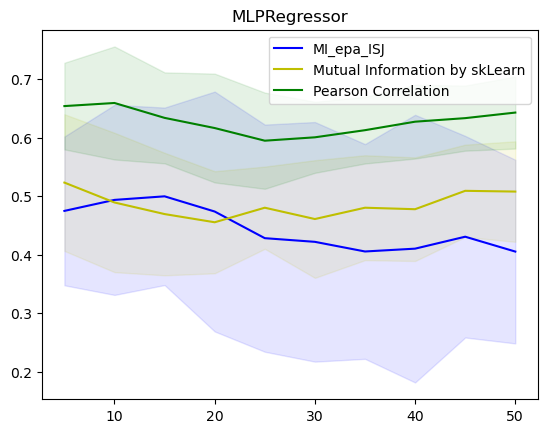

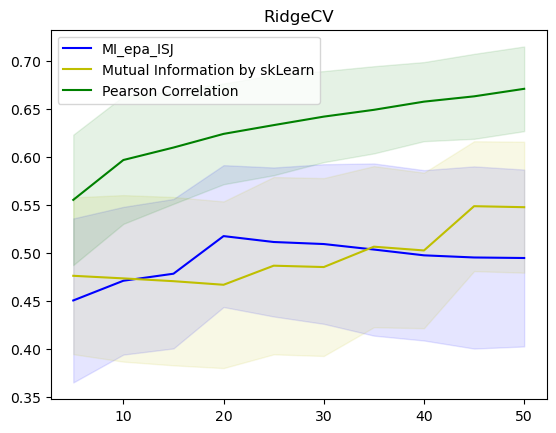

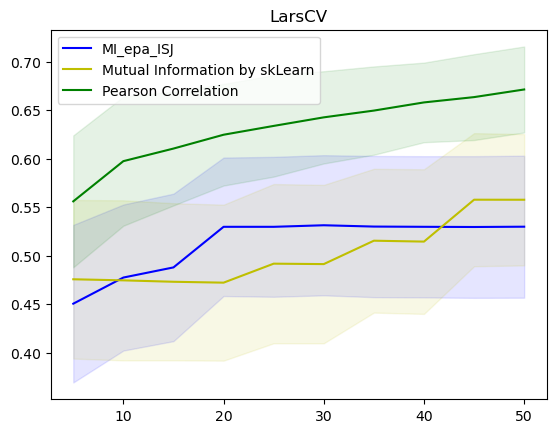

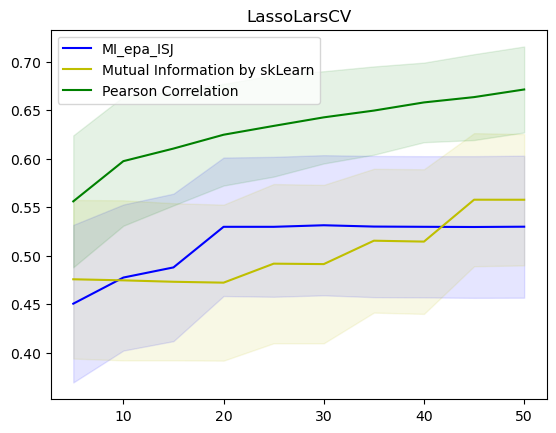

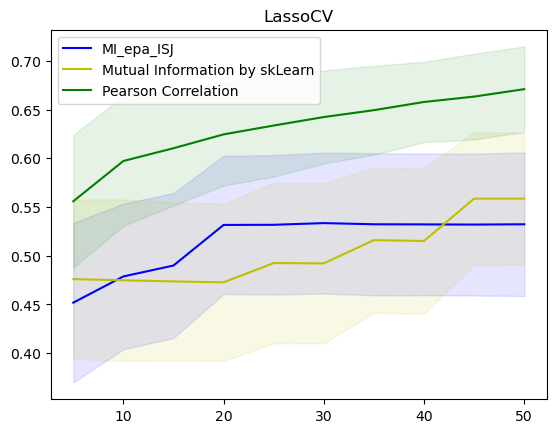

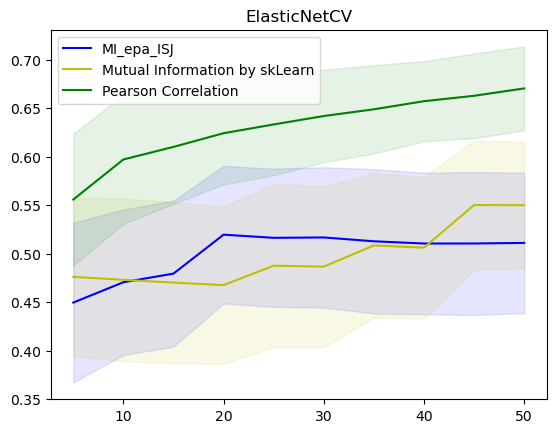

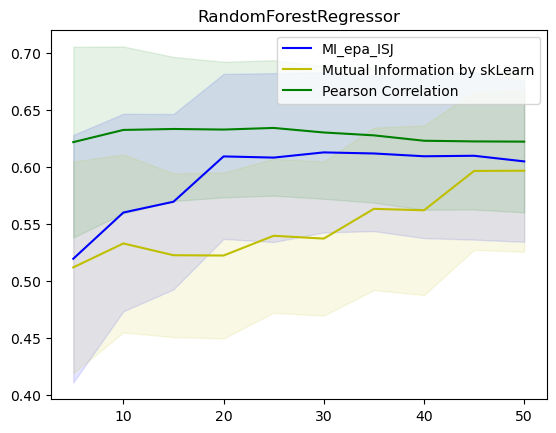

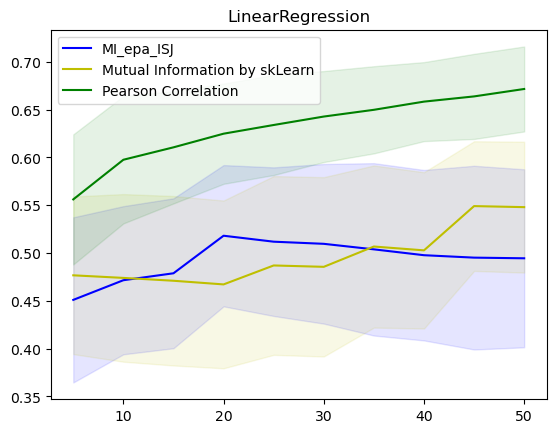

In [11]:
import os


def plot_results(_plt, fun_name, dep_measure):
    if os.path.isfile(
            r"./ABIDE_predict_age/ABIDE_age_{dep_measure}_{fun_name}.npy".
            format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name)) and os.path.isfile(
                r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
                    fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_{dep_measure}_{fun_name}.npy".
            format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_skMI_{fun_name}.npy".format(
                fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_predict_age/ABIDE_age_Pearson_{fun_name}.npy".format(
                fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label=dep_measure, color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information by skLearn",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)
        _plt.legend()


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPRegressor", "RidgeCV", "LarsCV", "LassoLarsCV", "LassoCV",
            "ElasticNetCV", "RandomForestRegressor", "LinearRegression"
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(r"./ABIDE_predict_age/" + fun_name + dep_measure)
            plt.show()

### using Bernstein polynomials of degree $3$

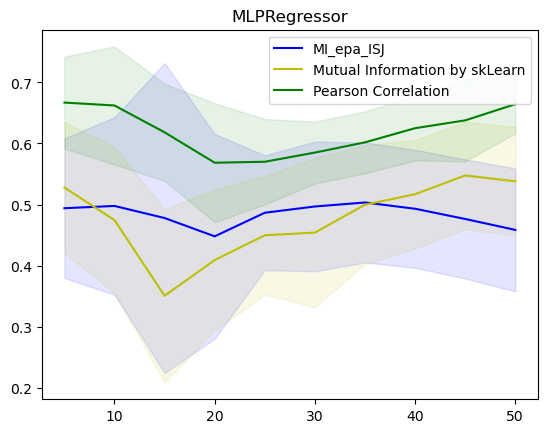

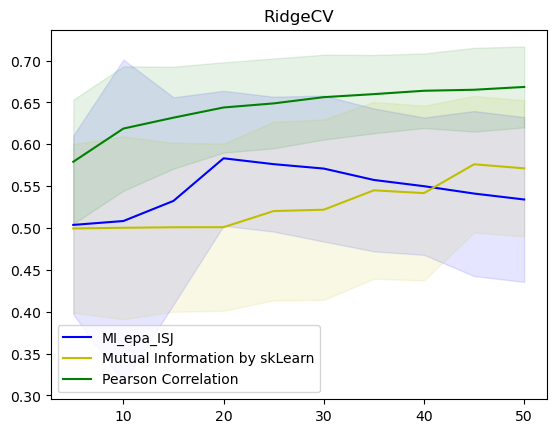

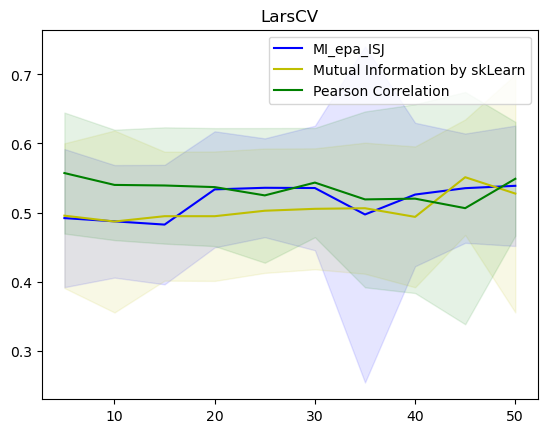

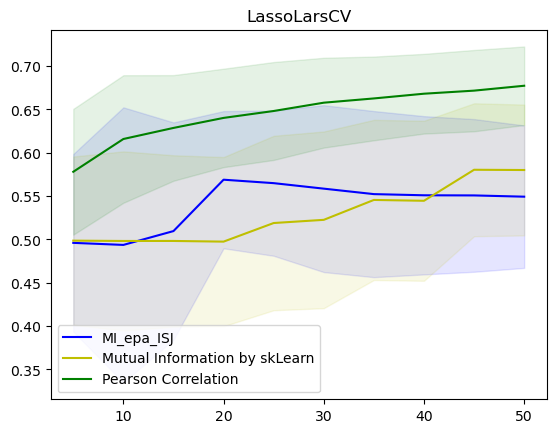

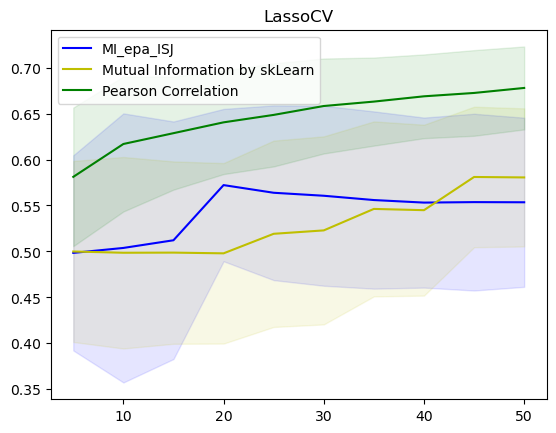

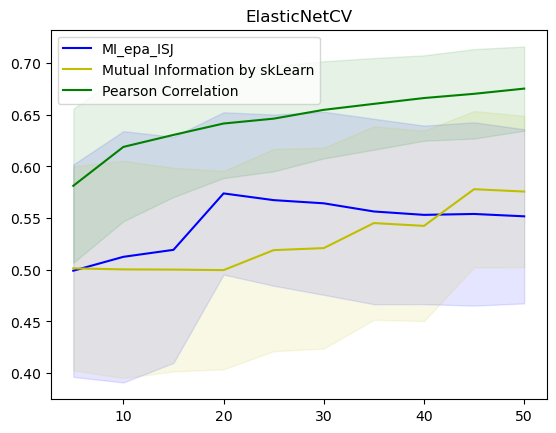

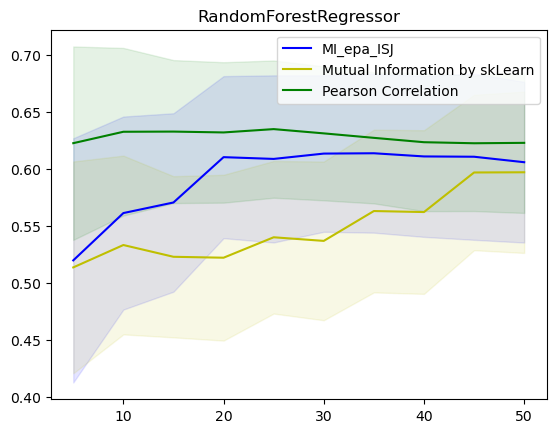

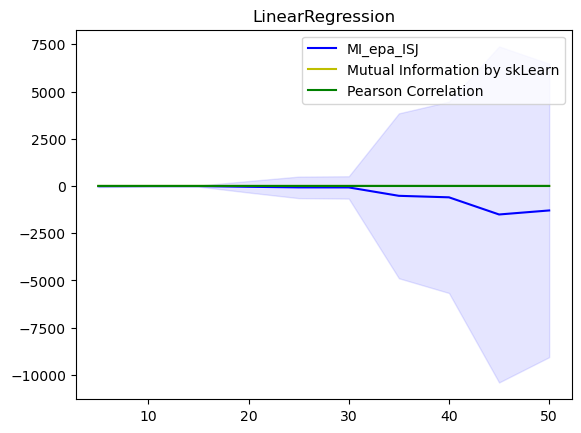

In [12]:
import os


def plot_results(_plt, fun_name, dep_measure):
    if os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_age_MI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_age_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_age_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_age/ABIDE_poly3_age_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_age_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_age_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_age_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_age_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_age_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_age_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label=dep_measure, color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information by skLearn",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)
        _plt.legend()


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPRegressor", "RidgeCV", "LarsCV", "LassoLarsCV", "LassoCV",
            "ElasticNetCV", "RandomForestRegressor", "LinearRegression"
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(r"./ABIDE_poly3_predict_age/" + fun_name + dep_measure)
            plt.show()

# Try Fitting models to predict diagnosis, $5$-fold CV
## create job submission scripts for `ABIDE_predict_diagnosis`

In [13]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
         fun_name + ".sh").touch()
    Path(r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
         fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
        fun_name + ".sh", "w")
    py_script = open(
        r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_" + dep_measure + "_" +
        fun_name + ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-masd
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=diagnosis_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.28
# pip install fastHDMI==1.18.28 --no-cache-dir
# pip wheel fastHDMI --no-deps

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 Cython
pip install --no-index /home/kyang/KDEpy-1.1.1+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.28-cp38-cp38-linux_x86_64.whl

nvidia-smi
lscpu

echo "running ABIDE_diagnosis_{dep_measure}_{fun_name}.py"

cp /home/kyang/ABIDE_data_analysis/ABIDE_PCA/ABIDE_PCA.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_diagnosis_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/ABIDE_PCA.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(
    os.environ["SLURM_TMPDIR"] +
    r"/ABIDE_diagnosis_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name,  # "SEX", "AGE_AT_SCAN",
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="DX_GROUP",
    num_rep=20)
np.save(r"./ABIDE_diagnosis_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LogisticRegressionCV_l1", "LogisticRegressionCV_l2",
        "LogisticRegressionCV_ElasticNet", "MLPClassifier",
        "RandomForestClassifier", "LogisticRegression"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [14]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
# !find . -name "*.py" -exec yapf --in-place "{}" \;
# !find . -name "*.py" -exec autopep8 --in-place "{}" \;

## create job submission scripts for `ABIDE_poly3_predict_diagnosis`

In [15]:
from pathlib import Path


def job_creator(dep_measure, fun_name):
    Path(r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
         dep_measure + "_" + fun_name + ".sh").touch()
    Path(r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
         dep_measure + "_" + fun_name + ".py").touch()
    bash_script = open(
        r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
        dep_measure + "_" + fun_name + ".sh", "w")
    py_script = open(
        r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_" +
        dep_measure + "_" + fun_name + ".py", "w")
    bash_script.write(r"""#!/bin/bash
#SBATCH --account=def-cgreenwo
#SBATCH --nodes=1
#SBATCH --cpus-per-task=10
#SBATCH --mem=80G
#SBATCH --time=3-12:00:00
#SBATCH --job-name=poly3_diagnosis_{dep_measure}_{fun_name}

module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle

virtualenv --no-download $SLURM_TMPDIR/env
source $SLURM_TMPDIR/env/bin/activate
pip install --no-index --upgrade pip

# ### run this block at the login node to build wheels
# module load gcc llvm rust arrow cuda nodejs python/3.8.10 r/4.0.2 python-build-bundle
# ### upgrading the tools
# pip install --upgrade pip setuptools wheel
# ### remove all old wheels
# rm *.whl
# ### get wheels builder
# git clone https://github.com/ComputeCanada/wheels_builder
# export PATH=$PATH:${{HOME}}/wheels_builder
# ### build KDEpy 1.1.1
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package KDEpy --version 1.1.1 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built nonconvexAG 1.0.6
# ${{HOME}}/wheels_builder/unmanylinuxize.sh --package nonconvexAG --version 1.0.6 --python 3.8,3.9,3.10 --find_links https://files.pythonhosted.org/packages/
# ### built fastHDMI 1.18.28
# pip install fastHDMI==1.18.28 --no-cache-dir
# pip wheel fastHDMI --no-deps

# Here basically to build the packages at login node and install them in slurm job submission locally
pip install --no-index bed-reader numpy sklearn matplotlib scipy numba multiprocess scikit-learn cupy rpy2 Cython
pip install --no-index /home/kyang/KDEpy-1.1.1+computecanada-cp38-cp38-linux_x86_64.whl
pip install --no-index /home/kyang/nonconvexAG-1.0.6+computecanada-py3-none-any.whl
pip install --no-index /home/kyang/fastHDMI-1.18.28-cp38-cp38-linux_x86_64.whl

nvidia-smi
lscpu

echo "running ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.py"

cp /home/kyang/ABIDE_data_analysis/ABIDE_PCA/ABIDE_PCA.csv $SLURM_TMPDIR/
cp ../ABIDE_columns.npy $SLURM_TMPDIR/
cp ../ABIDE_diagnosis_{dep_measure}_output.npy $SLURM_TMPDIR/

python3 ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.py
    """.format(dep_measure=dep_measure, fun_name=fun_name))
    py_script.write(r"""import numpy as np
import pandas as pd
from dask import dataframe as dd
import matplotlib.pyplot as plt
from scipy.stats import kendalltau, rankdata, norm
import fastHDMI as mi
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, SplineTransformer
from sklearn.decomposition import PCA
from sklearn.linear_model import LassoCV, ElasticNetCV, RidgeCV, LarsCV, LassoLarsCV, LogisticRegressionCV, LinearRegression, LogisticRegression
from sklearn.neural_network import MLPRegressor, MLPClassifier
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import r2_score, roc_auc_score
import multiprocess as mp
from tqdm import tqdm
import os

csv_file = os.environ["SLURM_TMPDIR"] + \
    r"/ABIDE_PCA.csv"
original_df = pd.read_csv(csv_file, encoding="unicode_escape", engine="c")

columns = np.load(os.environ["SLURM_TMPDIR"] + r"/ABIDE_columns.npy")
abide_dep = np.load(
    os.environ["SLURM_TMPDIR"] +
    r"/ABIDE_diagnosis_{dep_measure}_output.npy")  # dep_measure
abide_dep = np.absolute(abide_dep)


def binning(var, num_bins, min_num=2):
    bins = np.linspace(np.min(var) - 1e-8, np.max(var) + 1e-8, num_bins)
    var_binned = np.digitize(var, bins)
    category = np.sort(np.unique(var_binned))
    while len([
            x for x in category if np.count_nonzero(var_binned == x) < min_num
    ]) != 0:
        for j in range(len(category)):
            if j < len(
                    category
            ):  # since category is always updated, we add this to avoid out of index error; alternatively, a while loop also works
                if np.count_nonzero(
                        var_binned == category[j]
                ) < min_num:  # if the number of observations in a category is less than min_num
                    if j == 0:  # if it's the first category, combine it with the second
                        var_binned[var_binned == category[j]] = category[j + 1]
                    else:  # if it's not the first category, combine it with the previous one
                        var_binned[var_binned == category[j]] = category[j - 1]
                    category = np.sort(np.unique(var_binned))
    return var_binned


def LogisticRegressionCV_l1(**arg):
    return LogisticRegressionCV(penalty="l1",
                                solver="saga",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_l2(**arg):
    return LogisticRegressionCV(penalty="l2",
                                solver="lbfgs",
                                multi_class="ovr",
                                **arg)


def LogisticRegressionCV_ElasticNet(**arg):
    return LogisticRegressionCV(penalty="elasticnet",
                                solver="saga",
                                multi_class="ovr",
                                l1_ratios=np.linspace(0, 1, 12)[1:-1],
                                **arg)


def testing_error(num_covariates=20,
                  training_proportion=.8,
                  fun=ElasticNetCV,
                  outcome_name="AGE_AT_SCAN",
                  seed=1):
    np.random.seed(seed)
    _usecols = np.hstack((
        outcome_name,  # "SEX", "AGE_AT_SCAN",
        columns[np.argsort(-abide_dep)][:num_covariates]))
    df = original_df[_usecols].dropna(inplace=False).sample(
        frac=1, random_state=seed, replace=False).reset_index(drop=True,
                                                              inplace=False)
    if df.shape[0] > 20:
        X, y = df.iloc[:,
                       1:].to_numpy(copy=True), df.iloc[:,
                                                        0].to_numpy(copy=True)
        X = StandardScaler(copy=False).fit_transform(X)
        X = SplineTransformer(n_knots=2,
                              degree=3,
                              extrapolation="continue",
                              include_bias=False).fit_transform(X)
        X = StandardScaler(copy=False).fit_transform(X)
        # if the outcome is continuous, we have to use binning
        if fun in [
                ElasticNetCV, LassoCV, RidgeCV, LarsCV, LassoLarsCV,
                MLPRegressor, RandomForestRegressor, LinearRegression
        ]:
            y_binned = binning(y, 30, min_num=2)
        else:
            y_binned = y.copy()
        X_train, X_test, y_train, y_test = train_test_split(
            X,
            y,
            train_size=training_proportion,
            random_state=seed,
            stratify=y_binned)
        if fun in [ElasticNetCV, LassoCV]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RidgeCV]:  # RidgeCV doesn't have seed setting and n_jobs
            fit = fun(cv=5).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LarsCV, LassoLarsCV
                     ]:  # LarsCV doesn't have seed setting but have n_jobs
            fit = fun(cv=5, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPRegressor]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [MLPClassifier]:
            mlp_gs = fun(random_state=seed, max_iter=500)
            parameter_space = {{
                "hidden_layer_sizes": [(15, 15, 15, 15, 15, 15), (30, 20, 20),
                                       (500, )],
                "activation": ["tanh", "relu"],
                "solver": ["sgd", "adam"],
                "alpha": [0.0001, 0.05],
                "learning_rate": ["constant", "adaptive"]
            }}
            clf = GridSearchCV(mlp_gs, parameter_space, n_jobs=10, cv=5)
            clf.fit(X_train, y_train)
            y_pred = clf.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [
                LogisticRegressionCV_l1, LogisticRegressionCV_l2,
                LogisticRegressionCV_ElasticNet
        ]:
            fit = fun(cv=5, random_state=seed, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [RandomForestRegressor]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [RandomForestClassifier]:
            fit = fun(random_state=seed, n_jobs=10,
                      n_estimators=500).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
        elif fun in [LinearRegression]:
            fit = fun(n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict(X_test)
            out = r2_score(y_test, y_pred)
        elif fun in [LogisticRegression]:
            fit = fun(penalty=None, n_jobs=10).fit(X_train, y_train)
            y_pred = fit.predict_proba(
                X_test)[:, 1]  # predict probability to calculate ROC
            out = roc_auc_score(y_test, y_pred)
    else:
        out = np.nan
    return out


def testing_error_rep(num_covariates=20,
                      training_proportion=.8,
                      fun=ElasticNetCV,
                      outcome_name="AGE_AT_SCAN",
                      num_rep=10):
    def _testing_error(seed):
        return testing_error(num_covariates=num_covariates,
                             training_proportion=training_proportion,
                             fun=fun,
                             outcome_name=outcome_name,
                             seed=seed)

    seeds = np.arange(num_rep)
    return np.array(list(map(_testing_error, seeds)))


def testing_error_num_attr(num_attr,
                           training_proportion=.8,
                           fun=ElasticNetCV,
                           outcome_name="AGE_AT_SCAN",
                           num_rep=10):
    def _testing_error_rep(_num_attr):
        return testing_error_rep(num_covariates=_num_attr,
                                 training_proportion=training_proportion,
                                 fun=fun,
                                 outcome_name=outcome_name,
                                 num_rep=num_rep)

    return np.array(list(map(_testing_error_rep, tqdm(num_attr))))


print(r"ABIDE_poly3_age_{dep_measure}_{fun_name}")  # dep_measure, fun_name
output = testing_error_num_attr(
    num_attr=list(map(int,
                      np.around(np.linspace(0, 50, 10 + 1)[1:]).tolist())),
    training_proportion=.8,  # 80/20 training+validation/testing division
    fun={fun_name},  # fun_name
    outcome_name="DX_GROUP",
    num_rep=20)
np.save(r"./ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}",
        output)  # dep_measure, fun_name
    """.format(dep_measure=dep_measure, fun_name=fun_name))


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for fun_name in [
        "LogisticRegressionCV_l1", "LogisticRegressionCV_l2",
        "LogisticRegressionCV_ElasticNet", "MLPClassifier",
        "RandomForestClassifier", "LogisticRegression"
]:
    for dep_measure in [*dep_measure_list, "Pearson", "skMI"]:
        job_creator(dep_measure, fun_name)

In [16]:
#!find . -name "*.py" -exec yapf --in-place "{}" \;
#!find . -name "*.py" -exec autopep8 --in-place "{}" \;
!find . -name "*.py" -exec yapf --in-place "{}" \;
!find . -name "*.py" -exec autopep8 --in-place "{}" \;

# Comparison of Performance
## Here is just to show the testing set ROC
### using variables directly

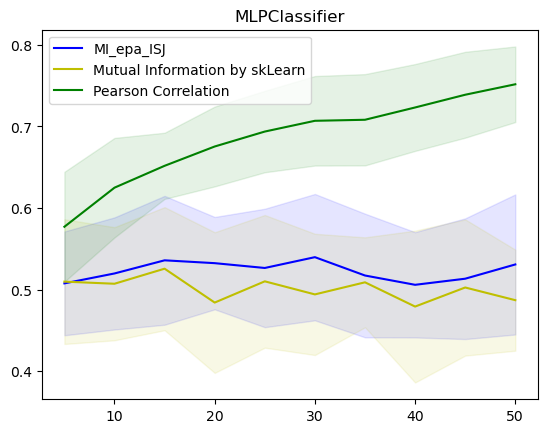

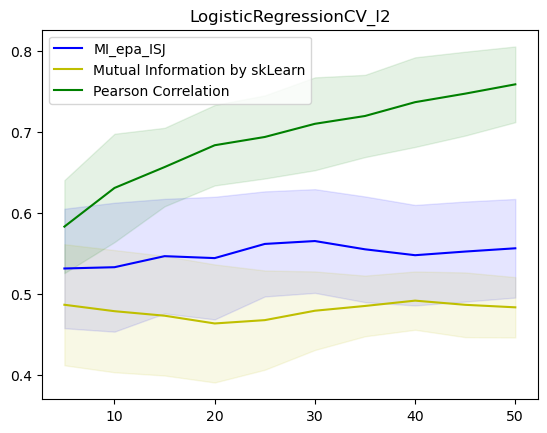

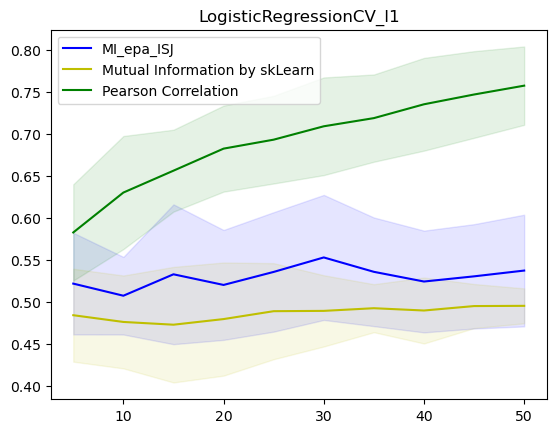

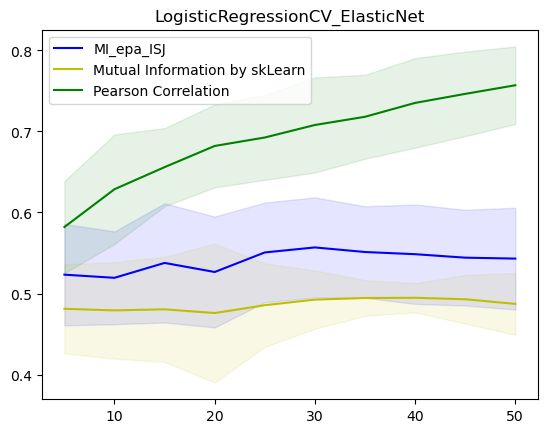

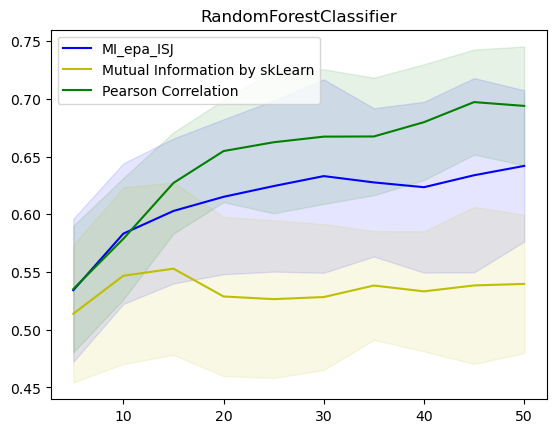

<Figure size 640x480 with 0 Axes>

In [17]:
import os


def plot_results(_plt, fun_name, dep_measure):
    if os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_skMI_{fun_name}.npy".
            format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_predict_diagnosis/ABIDE_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label=dep_measure, color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information by skLearn",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)
        _plt.legend()


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPClassifier", "LogisticRegressionCV_l2",
            "LogisticRegressionCV_l1", "LogisticRegressionCV_ElasticNet",
            "RandomForestClassifier", "LogisticRegression"
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(r"./ABIDE_predict_diagnosis/" + fun_name + dep_measure)
            plt.show()

### using Bernstein polynomials of degree $3$

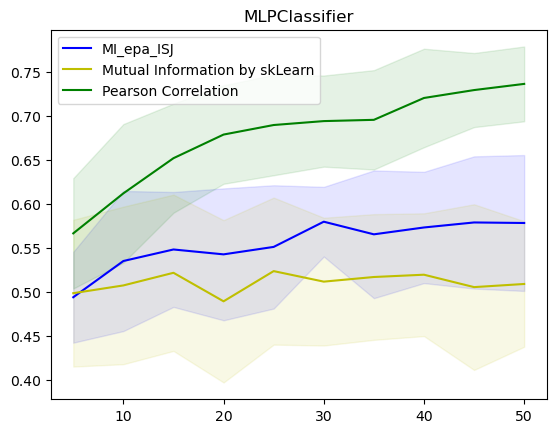

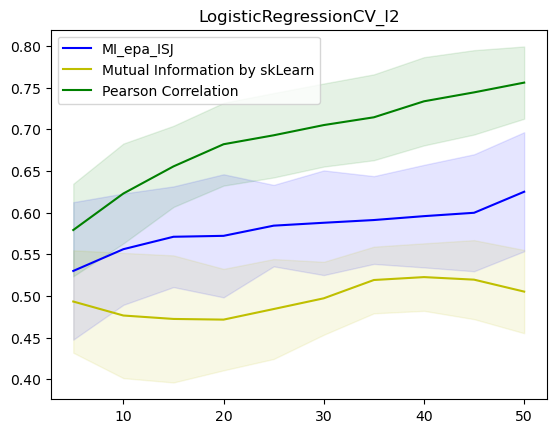

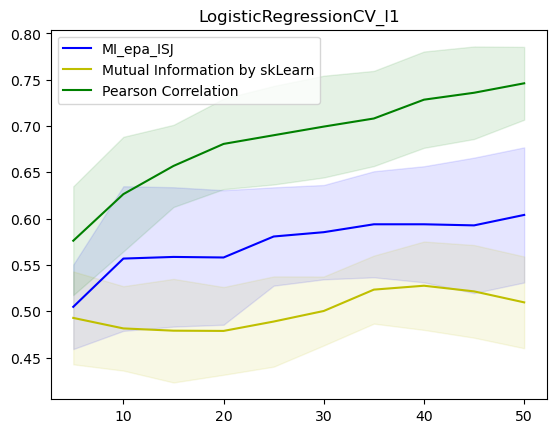

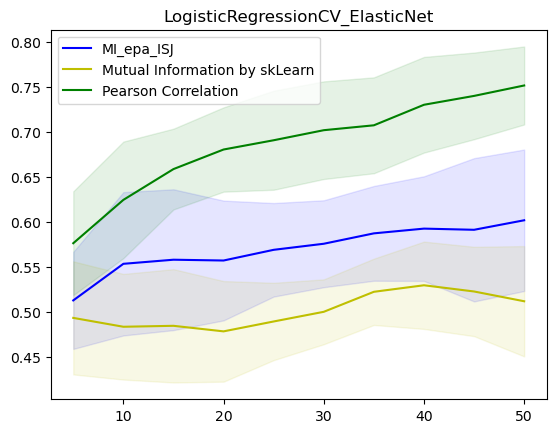

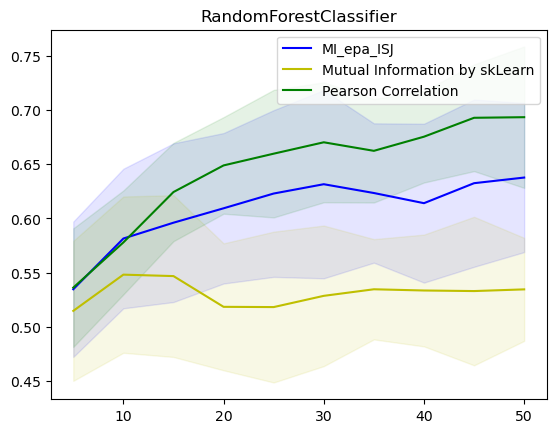

<Figure size 640x480 with 0 Axes>

In [18]:
import os


def plot_results(_plt, fun_name, dep_measure):
    if os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name)
    ) and os.path.isfile(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name)):
        columns = np.load(r"./ABIDE_columns.npy")
        ABIDE_diagnosis_MI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_{dep_measure}_{fun_name}.npy"
            .format(fun_name=fun_name, dep_measure=dep_measure))
        ABIDE_diagnosis_skMI_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_skMI_{fun_name}.npy"
            .format(fun_name=fun_name))
        ABIDE_diagnosis_Pearson_foo = np.load(
            r"./ABIDE_poly3_predict_diagnosis/ABIDE_poly3_diagnosis_Pearson_{fun_name}.npy"
            .format(fun_name=fun_name))
        num_attr = list(
            map(int,
                np.around(np.linspace(
                    0, 50, 10 +
                    1)[1:]).tolist()))  # ADJUST this based on actual settings

        MI_fit_mean = np.mean(ABIDE_diagnosis_MI_foo, 1)
        MI_fit_std = np.std(ABIDE_diagnosis_MI_foo, 1)
        skMI_fit_mean = np.mean(ABIDE_diagnosis_skMI_foo, 1)
        skMI_fit_std = np.std(ABIDE_diagnosis_skMI_foo, 1)
        Pearson_fit_mean = np.mean(ABIDE_diagnosis_Pearson_foo, 1)
        Pearson_fit_std = np.std(ABIDE_diagnosis_Pearson_foo, 1)

        _plt.plot(num_attr, MI_fit_mean, label=dep_measure, color="b")
        _plt.fill_between(num_attr,
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.025)),
                          (MI_fit_mean + MI_fit_std * norm.ppf(0.975)),
                          color="b",
                          alpha=.1)

        _plt.plot(num_attr,
                  skMI_fit_mean,
                  label="Mutual Information by skLearn",
                  color="y")
        _plt.fill_between(num_attr,
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.025)),
                          (skMI_fit_mean + skMI_fit_std * norm.ppf(0.975)),
                          color="y",
                          alpha=.1)

        _plt.plot(num_attr,
                  Pearson_fit_mean,
                  label="Pearson Correlation",
                  color="g")
        _plt.fill_between(
            num_attr, (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.025)),
            (Pearson_fit_mean + Pearson_fit_std * norm.ppf(0.975)),
            color="g",
            alpha=.1)
        _plt.title(fun_name)
        _plt.legend()


dep_measure_list = []
for _kernel in [
        'gaussian', 'exponential', 'box', 'tri', 'epa', 'biweight',
        'triweight', 'tricube', 'cosine'
]:
    for _bw in ['silverman', 'scott', 'ISJ']:
        dep_measure_list += ["MI_{kernel}_{bw}".format(kernel=_kernel, bw=_bw)]

for dep_measure in dep_measure_list:
    for fun_name in [
            "MLPClassifier", "LogisticRegressionCV_l2",
            "LogisticRegressionCV_l1", "LogisticRegressionCV_ElasticNet",
            "RandomForestClassifier", "LogisticRegression"
    ]:
        if dep_measure == "MI_epa_ISJ":
            plot_results(plt, fun_name, dep_measure=dep_measure)
            plt.savefig(r"./ABIDE_poly3_predict_diagnosis/" + fun_name +
                        dep_measure)
            plt.show()